Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

_Proszę pamiętać, że zadanie może wymagać odpowiedniego czasu na obliczenia. Nie polecamy wykonywać go na komputerach uczelnianych, tylko wykorzystać zasoby colaba (albo własne, jeśli państwo chcą). Ewentualne przyśpieszenie obliczeń można uzyskać korzystając z GPU w colabie, jeżeli nie dysponują państwo kartą NVidii albo nie chcą jej państwo używać (opisane w zadaniu 2*)_

Running on: cuda:0


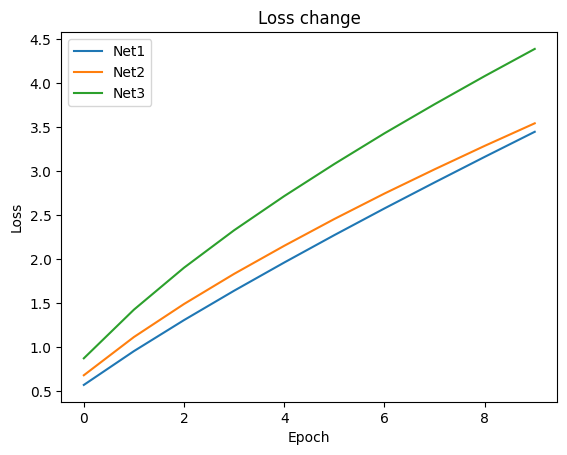

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.nn.functional as F
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
class Net1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
class Net2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 120)
        self.fc2 = nn.Linear(120, 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        o = self.pool(F.relu(self.conv2(o)))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class Net3(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        o = self.pool(F.relu(self.conv2(o)))
        o = self.pool(F.relu(self.conv3(o)))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
input_size = (1, 28, 28)
nets = [Net1(input_size).to(device), Net2(input_size).to(device), Net3(input_size).to(device)]
loss_function = nn.CrossEntropyLoss()
optimizers = [optim.Adam(net.parameters()) for net in nets]
losses = [[] for _ in range(len(nets))]
running_losses = [0] * len(nets)
for epoch in range(10):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        for net, optimizer in zip(nets, optimizers):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_losses[nets.index(net)] += loss.item()
    for j in range(len(nets)):
        losses[j].append(running_losses[j] / len(trainloader))
for i, loss in enumerate(losses):
    plt.plot(loss, label=f'Net{i+1}')
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Wnioski:**
Aby sieć poprawnie nauczyła się rozróżniać obrazy, należało dobrać odpowiedni batch_size. Przy zbyt małym wydłużał się czas nauki a przy zbyt dużym dokładność znacząco spadała. Znalezioną wartością optymalną okazało się 128.
Ilość warstw konwolucyjnych miała wpływ na parametr loss. Im większa ilość, tym szybciej narastał wraz z epokami.
W teorii nie powinno tak się dziać, jednak jest możliwość, że przez poziom trudności zadania, ilość danych uczących i wybór innych parametrów, mniejsza sieć okaże się lepsza.
Mechanizm dropout pomógł sieci w zapobieganiu overfittingu na zbiorze uczącym.

Dokładność sieci: 89 %
[[848   0  20  24   5   3  86   0  14   0]
 [  3 969   1  19   3   0   1   0   4   0]
 [ 16   2 859   7  64   0  48   0   4   0]
 [ 22   3  14 917  19   0  21   0   4   0]
 [  2   1  91  37 830   0  39   0   0   0]
 [  0   0   0   0   0 976   0  16   0   8]
 [137   3 108  29  93   0 619   0  11   0]
 [  0   0   0   0   0  23   0 952   1  24]
 [  4   0   5   5   1   2   2   4 977   0]
 [  0   0   0   0   0  11   1  34   0 954]]


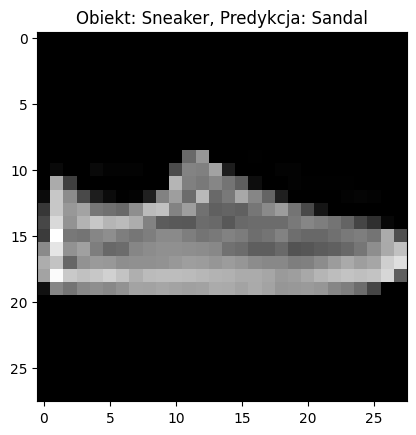

Dokładność sieci: 89 %
[[876   1   8  13   5   1  85   0  11   0]
 [  2 980   0  12   2   0   3   0   1   0]
 [ 16   1 832   6  80   0  61   0   4   0]
 [ 21   6  11 895  35   0  28   0   4   0]
 [  2   1  47  27 874   0  46   0   3   0]
 [  0   0   0   0   0 968   0  20   2  10]
 [147   1  69  29  98   0 642   0  14   0]
 [  0   0   0   0   0  21   0 947   1  31]
 [  3   1   2   7   2   2   4   5 974   0]
 [  0   0   0   0   0   6   0  35   1 958]]


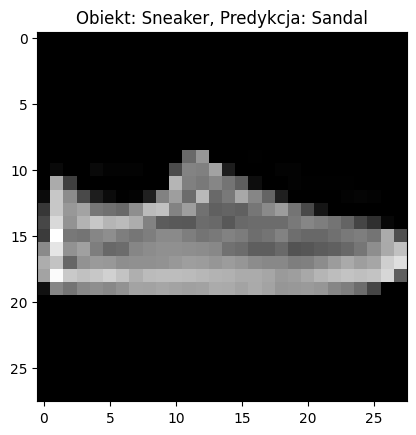

Dokładność sieci: 88 %
[[804   0  12  39   4   4 121   0  16   0]
 [  0 969   0  19   3   2   5   0   2   0]
 [ 11   1 807  18  90   1  68   0   4   0]
 [ 12   5   6 921  26   0  28   0   2   0]
 [  1   1  44  32 861   1  59   0   1   0]
 [  1   0   0   2   0 954   0  28   1  14]
 [116   0  68  36 101   0 657   0  22   0]
 [  0   0   0   0   0  19   0 959   0  22]
 [  1   0   1   5   2   5   9   4 972   1]
 [  0   0   0   0   0   4   0  40   0 956]]


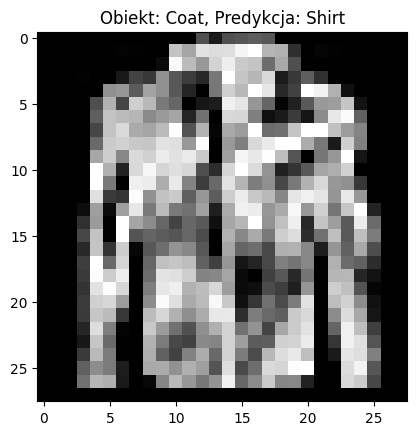

In [4]:
for net in nets:
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print('Dokładność sieci: %d %%' % (100 * correct / total))
    print(confusion_matrix(all_labels, all_preds))
    misclassified_index = next((index for index, (label, pred) in enumerate(zip(all_labels, all_preds)) if label != pred), None)
    if misclassified_index is not None:
        plt.imshow(testset[misclassified_index][0].numpy().squeeze(), cmap='gray')
        plt.title(f'Obiekt: {testset.classes[all_labels[misclassified_index]]}, Predykcja: {testset.classes[all_preds[misclassified_index]]}')
        plt.show()

**Wnioski:**
Dokładność dla każdej ilości warstw konwolucyjnych okazała się zbliżona do siebie, co sugeruje, że problem nie wymaga więcej niż jednej warstwy.
Patrząc na obrazy, przy których sieć popełniła błędy, można zauważyć, że obiekt który został wybrany a jego rzeczywisty odpowiednik są bardzo podobne w strukturze, jak sandał a but sportowy.

In [2]:
import torch
print('Czy mam CUDA?', torch.cuda.is_available() )
x = torch.cuda.current_device() # zwraca ID urządzenia
print('Nazwa GPU x:',torch.cuda.get_device_name(x))
print('Wersja CUDNN:', torch.backends.cudnn.version())
print('Ilość urządzeń CUDA:', torch.cuda.device_count())
print('Nazwa urządzenia CUDA: ',torch.cuda.get_device_name(0))
print('Pamięć urządzenia CUDA [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Czy mam CUDA? True
Nazwa GPU x: NVIDIA GeForce RTX 4070
Wersja CUDNN: 8801
Ilość urządzeń CUDA: 1
Nazwa urządzenia CUDA:  NVIDIA GeForce RTX 4070
Pamięć urządzenia CUDA [GB]: 12.878086144


**Wnioski:**
Konfigurując cuda na własnym komputerze Windows, trzeba było bardzo uważać na używane wersje Torch oraz CUDA, ponieważ muszą być one ze sobą w 100% kompatybilne.